In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from shap import TreeExplainer, decision_plot, Explainer
from shap.plots import beeswarm
import matplotlib.pyplot as plt

#### Basic preprocessing

In [3]:
df = pd.read_csv('data/strat.csv')
df.dropna(subset=['MPCE_qrt'], inplace=True)

# Rename state codes to state names
states = pd.read_csv('data/state_codes.csv', header=None, index_col=0)[1].to_dict()
df['state_codes'].replace(states, inplace=True)

# Process binary columns, those that need not be one-hot encoded
df['Urban'] = (df['sector'] == 'Urban').astype(int)
df['HH with children below age 6'] = (df['child'] == 'HH with children beloww age 6 ').astype(int)
df['Piped Gas/LPG Present'] = (df['piped_gas'] == 'Piped Gas/LPG Present').astype(int)

# Rename MPCE quartiles to be more readable
df['MPCE_qrt'].replace({'50-75': 'Third MPCE Quartile', '0-25': 'Lowest MPCE Quartile', '25-50': 'Second MPCE Quartile', '75-100': 'Top MPCE Quartile'}, inplace=True)

df.head()

,Age,Gender,state_codes,Total Children in HH,Total Women in HH,Total Additional Women in HH,education,marital_status,employment,Social_group_,...,Time Spent Cleaning,Time Spent Collecting Firewood,Time Spent Washing,Time Spent on Domestic Chores,Time Spent on Care Work,young_old,stratcode,Urban,HH with children below age 6,Piped Gas/LPG Present
0,67,Male,Tamil Nadu,1.0,2,1,Secondary,Currently Married,Self-Employed,OBC,...,0.0,0.0,0.0,0.0,45.0,Old,Old_TN_Male_OBC_Hinduism_Rural,0,1,1
1,61,Female,Tamil Nadu,1.0,2,1,Upto Middle School,Currently Married,Casual Labour,OBC,...,0.0,0.0,0.0,165.0,60.0,Old,Old_TN_Female_OBC_Hinduism_Rural,0,1,1
2,33,Male,Tamil Nadu,1.0,2,1,Secondary,Currently Married,Salaried Employee,OBC,...,0.0,0.0,0.0,0.0,15.0,Young,Young_TN_Male_OBC_Hinduism_Rural,0,1,1
3,26,Female,Tamil Nadu,1.0,2,1,Secondary,Currently Married,Not Employed,OBC,...,90.0,0.0,120.0,345.0,120.0,Young,Young_TN_Female_OBC_Hinduism_Rural,0,1,1
4,70,Female,Tamil Nadu,0.0,1,0,Illiterate,Widowed,Not Employed,OBC,...,0.0,0.0,0.0,105.0,0.0,Old,Old_TN_Female_OBC_Hinduism_Rural,0,0,1


In [4]:
def modify_ax(ax, title):
    """Shap's beeswarm plots offer very little customization by themselves.
    Use this function to modify the axis objects."""
    ax.set_title(title, fontsize='x-large', pad=20)
    ax.tick_params(axis='y', labelsize='large')
    ax.set_xlabel('Deviation from average time spent (in hours)', fontsize='large')

### Eqn 3: Determinants of time spent on various activities by women.

The following cell attempts to fit 9 different regression models with `sklearn.ensemble.RandomForestRegressor`, for modelling the time spent by women on:

* Paid work
* Unpaid work
* Leisure
* Cooking
* Cleaning
* Collecting firewood
* Washing
* Chores
* Care work

Once the regressors are fitted, we use `shap.plots.beeswarm` visualizations to see which features most affect the respective targets (the relative magnitudes and signs of the impact).

**The Problem**:
While most inferences from the beeswarm plots are sensible, they seem to suggest, surprisingly, that having a child less than 6 years old negatively impacts cooking, cleaning, washing and chores.
In other words, the models suggest that having a young child _reduces_ the time spent on cooking, cleaning, washing and domestic chores.
This does not make sense. Paraphrasing Prof Deshpande, there's not a shred of evidence for this elsewhere.

In [5]:
target_cols = [
    'Time Spent on Paid Work',
    'Time Spent on Unpaid Work',
    'Time Spent on Leisure',
    'Time Spent Cooking',
    'Time Spent Cleaning',
    'Time Spent Collecting Firewood',
    'Time Spent Washing',
    'Time Spent on Domestic Chores',
    'Time Spent on Care Work']
# Restrict to women
xdf = df[df['Gender'] == 'Female']

num_cols = ['Age', 'n_unemp_men', 'Urban', 'Piped Gas/LPG Present', 'HH with children below age 6']  # Also includes the previously encoded binary columns
cat_cols = ['Social_group_', 'religion', 'MPCE_qrt', 'education', 'employment', 'marital_status', 'wired_source', 'sweeeping_type',  'old', 'n_unemp_men', 'state_codes']


xCat = pd.get_dummies(xdf[cat_cols], prefix='', prefix_sep='', dtype=int)
xNum = xdf[num_cols]
X = pd.concat((xCat, xNum, xdf[target_cols]), axis=1)

**_Caution_**: The beeswarm plots take a long time. Reduce the `n_samples` variable below to get faster results, but with fewer samples.

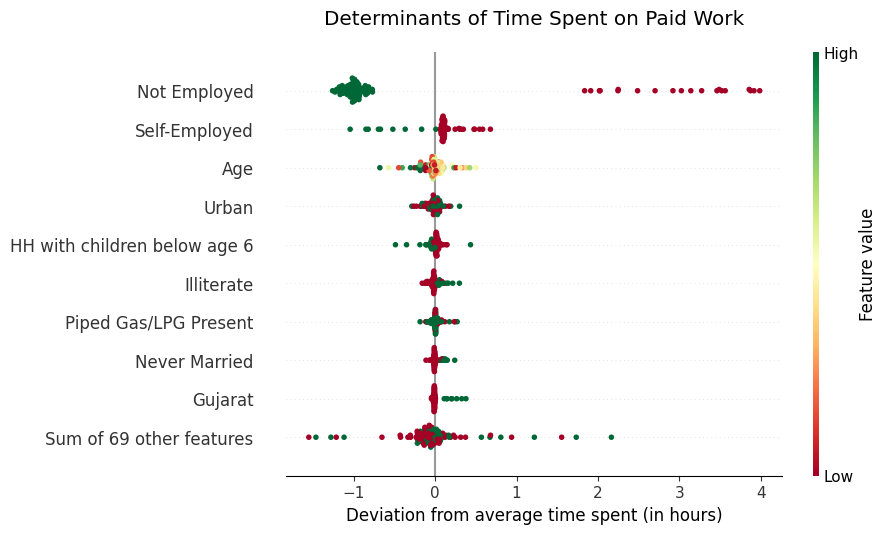

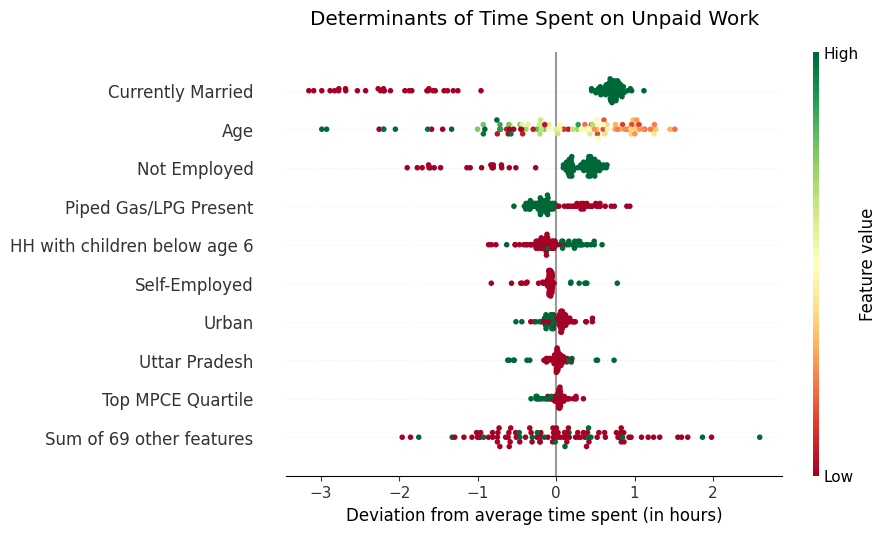

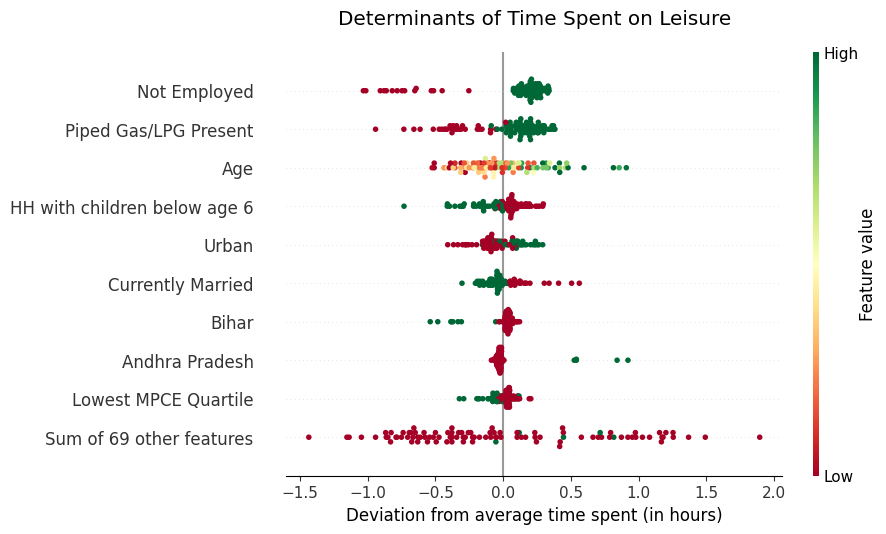

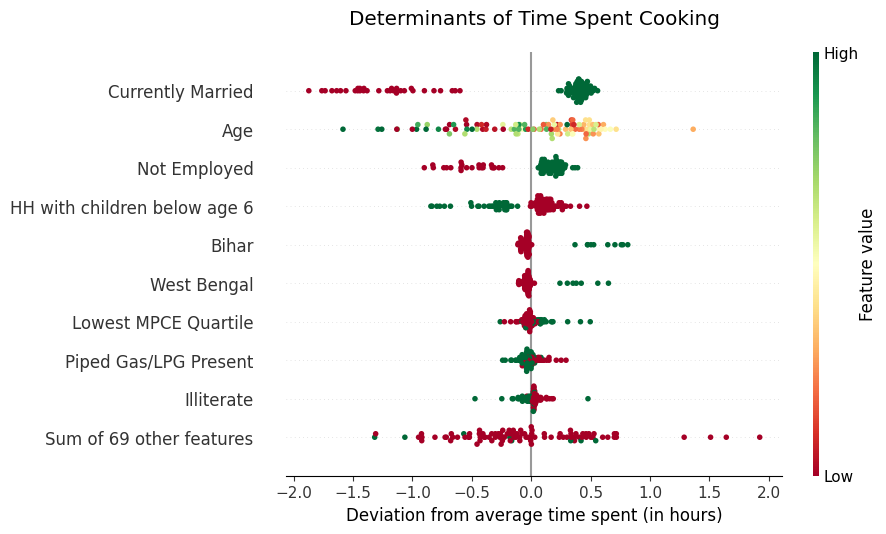

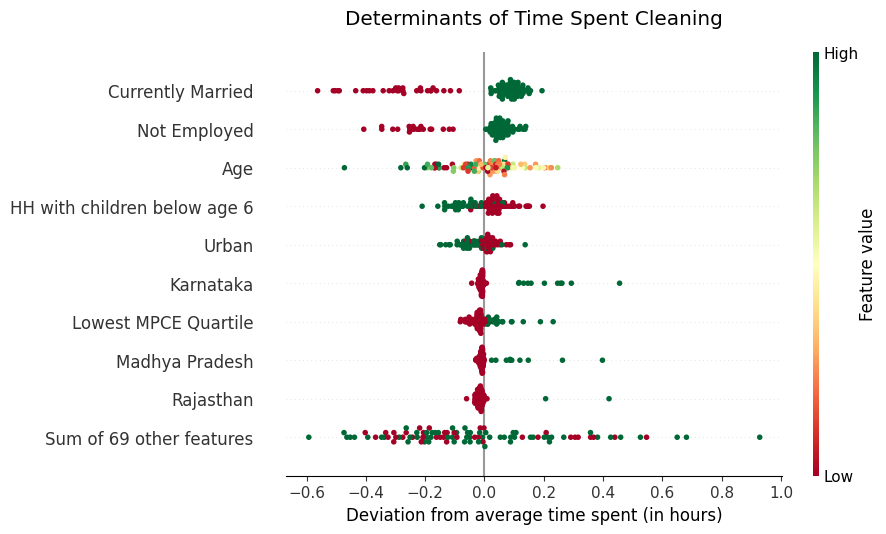

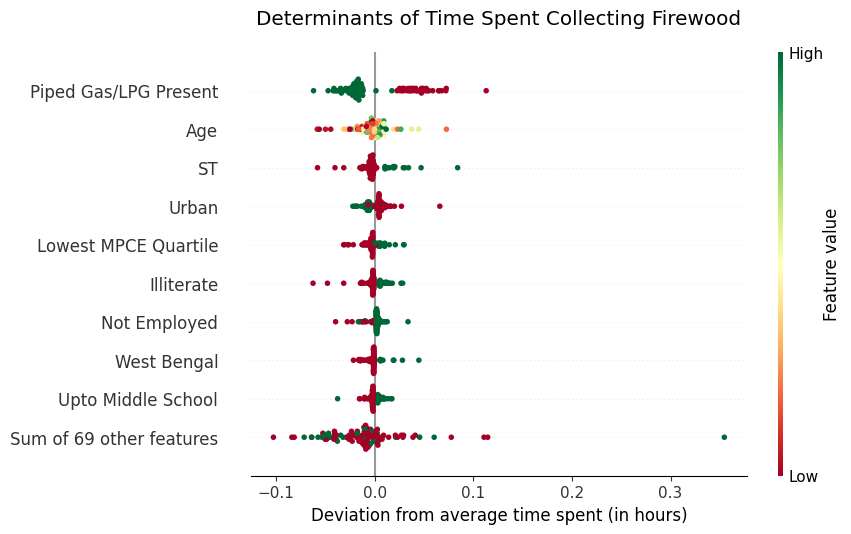

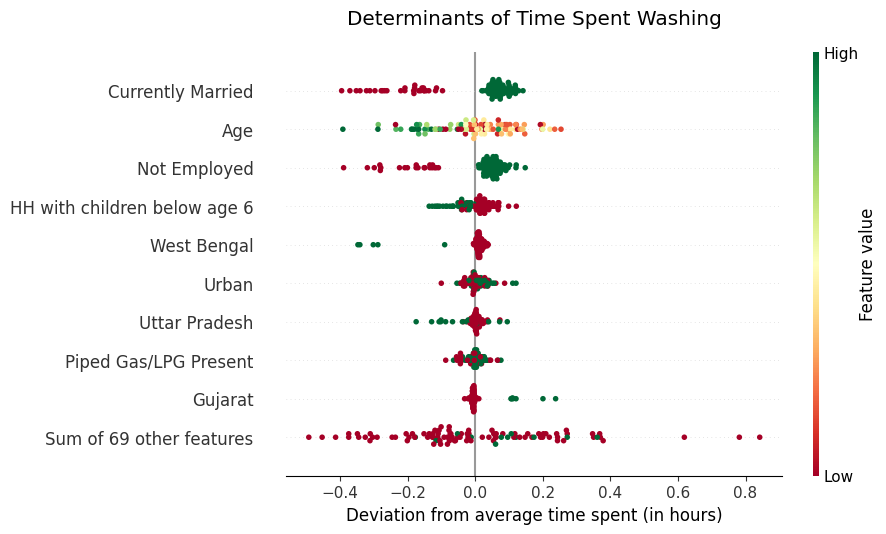

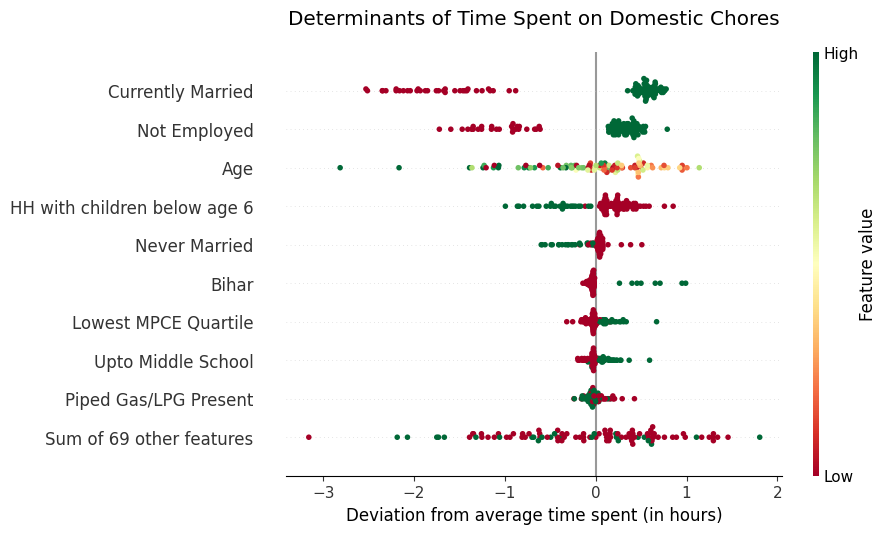

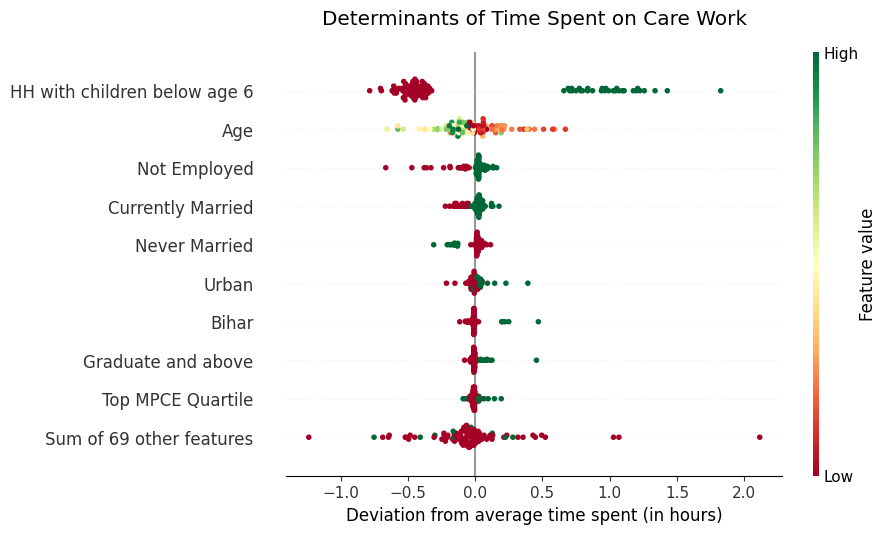

In [6]:
n_samples = 100

for t in target_cols:
    xtrain = X.drop(target_cols, axis=1)
    ytrain = X[t]
    clf = RandomForestRegressor(n_estimators=40, n_jobs=-1)
    clf.fit(xtrain, ytrain / 60)

    exp = TreeExplainer(clf, feature_perturbation='tree_path_dependent')
    vals = exp(xtrain.sample(n_samples), check_additivity=False)
    
    plt.figure()
    beeswarm(vals, color='RdYlGn', show=False)
    modify_ax(plt.gca(), f"Determinants of {t}")